# 2 Compouse an expression matrix with raw counts

Cynthia Soto <br>
Date: 5 de Octubre 2020 <br>
Last md: 23 de Marzo 2021 <br>

**Assumptions:** <br>
Data are expression profiles from RNASeq e.g: files generated with HTSeq tool <br>
All the raw count are allocated in a specific folder. <br>
**This is a custom script to integrate several raw-count files from Arabidopsis (Col-0) Healthy and Infected.** <br>

**Workflow:** <br>
1) Compouse the expr matrix from a dataset of raw count files <br>
2) Get some stats and distributions.  <br> 
3) Remove genes with ceros across all samples.  <br>
4) And plot again.  <br>

In [2]:
# Libraries required
import os 
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [47]:
#  @dir_to_parse        Set the folder to be parse (the raw count must to be there)
#  @general_titles      This var is used to label the plots and save the temporary files. 

###   Here I am retrieving the healthy datasets
#dir_to_parse='athal1_htseq-counts/'
#general_titles="healthy"

###   Here I am retrieving the infected datasets
dir_to_parse='athal3_htseq-counts/'
general_titles=" infected "

try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/"+dir_to_parse)
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")        
#print(os.listdir(os.getcwd())       

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts


### Declare functions 

In [48]:
# Rename columns on  a df according to the samples IDs (or whatever that you decide for the visualizations)
def set_ID_samples(df):
    df = df.rename(columns={'SRR10586397': 'Bc24', 'SRR364399':'Ch40.3','SRR364401':'Ch40',
                                         'SRR6283148':'Ss30','SRR6283147':'Ss30.1','SRR3383696':'Bc12',
                                         'SRR3383780':'Bc18','SRR6283146':'Ss30.2','SRR3383779':'Bc18.1',
                                         'SRR3383697':'Bc12.1','SRR364390':'Ch22','SRR364389':'Ch22.1',
                                         'SRR364400':'Ch40.1','SRR364391':'Ch22.2','SRR10586399':'Bc24.1',
                                         'SRR364392':'Ch22.3','SRR364398':'Ch40.2',
                                         'SRR3383821': 'healthy24', 'SRR3383783':'healthy18.1','SRR3383822':'healthy24.1',
                                         'SRR3383640':'healthy12','SRR3383641':'healthy12.1','SRR6283145':'healthy30.1',
                                         'SRR3383782':'healthy18','SRR6283144':'healthy30'})
    return df 

In [6]:
# Set ID index as "ID" to a describe() function in a df
def df_with_label_ID(df_stat):
    df_stat.reset_index(level=0, inplace=True)
    df_stat.rename(columns={'index': 'ID'}, inplace=True)
    
    ## use this chunk if you want to give IDs to a describe() functions from a external meta-data
    #     file='../meta-data/ID_samples.csv'
    #     df_meta=pd.read_csv(file, sep='\,', engine='python', usecols=[0,4]) 
    #     #print(df_meta.head(5))
    #     ## merge by sample field
    #     df = pd.merge(df, df_meta, on="sample")    
    df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    return df_stat 

In [7]:
## Function to remove genes from a df based on a list of indexes provided of the df
def df_drop_idx_list(df_idx, df_d):  #, df1_d

    ## get a list of gene idx to be remove provided in the df_idx 
    ## drop this idx list from the df provided (df_d)
    ## return the df with the idx provided removed
    
    ## Get the indexes of the gene rows to delete from the df provided
    lst_genes_to_drop=(df_idx.index)
    ## drop the idx marked    
    for i in lst_genes_to_drop: 
        try:
            df_d = df_d.drop([i])
        except:
            pass # doing nothing on exception, not processed because it is already dropped"
    
    return df_d 

In [8]:
# Filter a dataframe by the value of a column (I used to set a cutoff threshold)
def filter_df(df, *args):

    # Input: df is the dataframe to filter and *args are the criteria to apply
    # output: a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] >= v]
    return df_cut

In [9]:
# plot a bar chart from the describe() function of the specific df
def plot_intercuartile_bar(df, title, y_label):
    ax = df.plot(x="ID", y="75%", kind="bar", figsize=(10,7))
    df.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
    df.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
    df.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

In [10]:
# plot a line chart from the mean and STD from the describe() function of the specific df
def plot_mean_sdev_line(df, title, y_label):
    ## gca stands for 'get current axis'
    ax = plt.gca()
    df.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
    df.plot(kind='line',x='ID',y='std', color='red', ax=ax)
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    return

### Integration of all data files (samples) in one matrix 

In [12]:
## check a bit of the files to be processed ... are they ok?
s_path = str(os.getcwd())+'/SRR*'  
all_files = glob.glob(s_path)
for file in all_files:
    print(file)

/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR6283147
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR3383696
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364398
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364391
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364389
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364390
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR6283146
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364392
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR3383697
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR10586399
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR3383779
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/ath

### Integrate raw count files into a single dataframe (matrix)

In [13]:
all_files = glob.glob(s_path)
## To load the main df
flag_b=True

for file in all_files:
    #print(file)
    # get the base name from a 'linux path' 
    sample = os.path.basename(file)

    if flag_b:    ## load main df once
        ## Main df is df1
        df1=pd.read_csv(file, sep='\t')    ## nrows=100, usecols=[0,1]
        df1.columns = ["Genes","Counts"]
        print(df1.head(3))
        ## remove lastest n rows refering to HTSeq stats (these are not counts)
        df1.drop(df1.tail(5).index,inplace=True) 
        ## remove unnamed cols
        df1.drop(df1.columns[df1.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)
        df1.rename(columns={'Counts':sample},inplace=True)
        #print(df1.head(3)) 
        flag_b=False
    else:
        #print(file)
        df2= pd.read_csv(file, sep='\t')    
        df2.columns = ["Genes","Counts"]
        ## remove lastest n rows refering to HTSeq stats (these are not counts)
        df2.drop(df2.tail(5).index,inplace=True) 
        ## remove unnamed cols
        df2.drop(df2.columns[df2.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)      
        ## compare matrix gene_names before concatenated
        comparison_column = np.where(df1["Genes"] == df2["Genes"], True, False)
        if (False in comparison_column):
            print("Gene_names are not the same. Matrix "+file+" will not be concatenated.")
        else:
            ## merge matrix based in column name "Genes"
            df2.rename(columns={'Counts':sample},inplace=True)
            df1=df1.merge(df2,on=['Genes'],how='left')
            

       Genes  Counts
0  AT1G01020      40
1  AT1G01030      33
2  AT1G01040      57


In [14]:
df1.head(5)

,Genes,SRR6283147,SRR3383696,SRR364398,SRR364391,SRR364389,SRR364390,SRR6283146,SRR364392,SRR3383697,SRR10586399,SRR3383779,SRR364399,SRR364400,SRR3383780,SRR10586397,SRR6283148,SRR364401
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525


In [17]:
# call a function to set label sample's as IDs
df1 = set_ID_samples(df1)

## Some stats of the new df

1) Descriptive stats are calculate on the new df<br>
2) IDs of genes with cero counts across all the samples are identified and summarized.<br>
3) IDs identified are dropped from the the df to compose a new df filtered. <br>

In [18]:
df_plot=df1.describe().T
df_plot.head(5)

,count,mean,std,min,25%,50%,75%,max
Ss30.1,27654.0,220.027,1785.209,0.0,0.0,3.0,50.00,113794.0
Bc12,27654.0,399.494,2197.593,0.0,0.0,57.0,315.00,196583.0
Ch40.2,27654.0,315.562,1396.964,0.0,0.0,38.0,229.00,71578.0
Ch22.2,27654.0,328.425,1368.659,0.0,0.0,59.0,299.00,111911.0
Ch22.1,27654.0,329.295,1504.571,0.0,0.0,55.0,290.75,151388.0


In [19]:
## call the fuction df_with_label_ID
df_plot = df_with_label_ID(df_plot)
df_plot.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
1,Bc12,27654.0,399.494,2197.593,0.0,0.0,57.0,315.0,196583.0
8,Bc12.1,27654.0,494.320,2870.421,0.0,0.0,68.0,375.0,257238.0
13,Bc18,27654.0,416.255,1962.741,0.0,0.0,55.0,335.0,165685.0
10,Bc18.1,27654.0,312.448,1682.586,0.0,0.0,42.0,238.0,162222.0
14,Bc24,27654.0,662.250,2641.587,0.0,2.0,110.0,551.0,180982.0


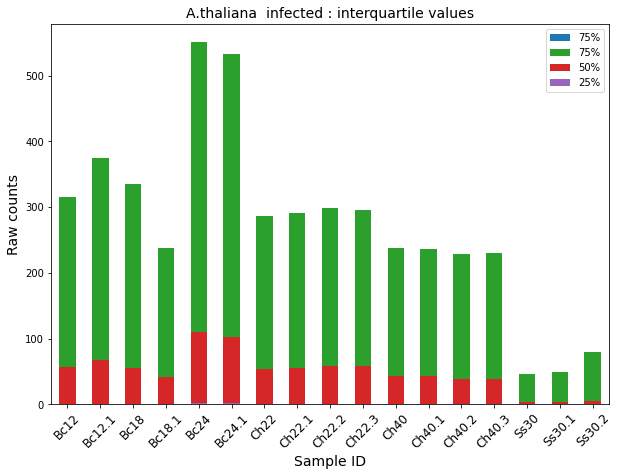

In [21]:
plot_intercuartile_bar(df_plot, 'A.thaliana '+ general_titles +': interquartile values', 'Raw counts')

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


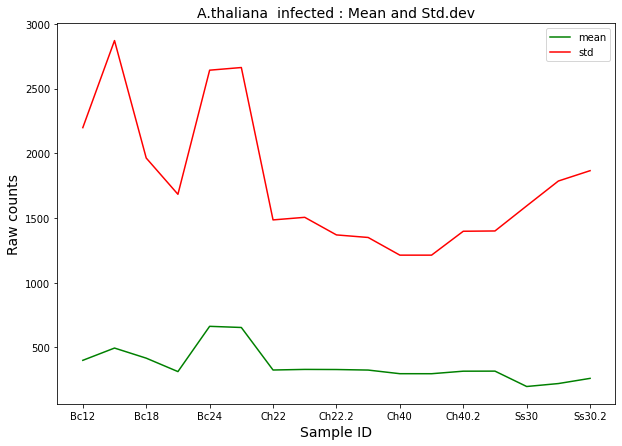

In [22]:
plot_mean_sdev_line(df_plot, 'A.thaliana '+ general_titles +': Mean and Std.dev','Raw counts' )

### Check for genes with zeros across all samples

In [23]:
df1.head(5)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525


In [24]:
## Check number of zeros by sample
sr_ceros = df1.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

## format the df (idx)
df_ceros.columns = df_ceros.iloc[0]
df_ceros = df_ceros.drop(df_ceros.index[0])
#df_ceros.head()

## call a function to set ID labels 
df_ceros = df_with_label_ID(df_ceros)
df_ceros.head(5)
#df_ceros.to_csv("../results-data/healthy_zeros_bysample.csv", index=False, header=True)

Genes,ID,0
1,Bc12,7518
8,Bc12.1,7375
13,Bc18,7549
10,Bc18.1,7719
14,Bc24,5627


***Here, zeros are counted by genes across all samples & a new column with the zero-counter values is appended to the matrix*** <br>
We're going to create the file called: **all_healthy_counterOFzeros.csv** contains the counter of zeros by gene <br>

In [25]:
s_zeros=(df1 == 0).astype(int).sum(axis=1)
#print(s_zeros)
#type(s_zeros)    ### build a serie-pandas
## Desglozando la formula
#(df1 == 0)
#(df1 == 0).astype(int)
#(df1 == 0).sum(axis=1)

## Added a column to df1 with the counter of zeros
df1['zero-counter'] = s_zeros
df1.head(3)
## Send the new matrix to all_healthy_counterOFzeros.csv 
#df1.to_csv('../results-data/all_healthy_counterOFzeros.csv', sep='\t', index=False)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127,0
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13,0
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647,0


In [26]:
general_titles

' infected '

Here, we look for genes with n number of ceros <br>
We create the file called: **all_[infected/healthy]_genes_w n zeros.csv** contains the detail of these genes with cero counts across all samples <br>

In [29]:
## Filter is looking for genes with 8 zeros across all samples in the healthy df (we have 8 samples for control)
##                   and genes with 17 zeros across all samples in the infected df (we have 17 samples infected)
if general_titles == 'healthy':
    is_zero = (df1['zero-counter']>=8)     
    df_zero = df1[is_zero]
    #df_zero.to_csv('../results-data/tmp/all_healthy_genes_w8zeros.csv', sep='\t', index=False)
else:
    is_zero = (df1['zero-counter']>=17)     
    df_zero = df1[is_zero]
    #df_zero.to_csv('../results-data/tmp/all_healthy_genes_w17zeros.csv', sep='\t', index=False)
print(df_zero.shape)
df_zero.head(7)
## save the result as tmp result


(3415, 19)


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
32,AT1G01335,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
41,AT1G01410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
109,AT1G02067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
125,AT1G02210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
155,AT1G02490,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
160,AT1G02540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
161,AT1G02550,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17


### Trimming genes with zeros across all samples
We need to remove the genes that do not provide any useful information in a gene coexpression analysis<br>
<br>
This means that if the size of the whole dataset is 8 samples, then 8 is the maximum number of zeros that a gene can reach. <br>

In [30]:
## Save the gene IDs with ceros in a file 
genes_cero_ToList = list(df_zero['Genes'])
with open("../results-data/all_"+ general_titles +"_geneIDs_with_zeros.csv", "w") as outfile:
    outfile.write("\n".join(str(item) for item in genes_cero_ToList))

In [31]:
## Here, we count how many genes are not expressed in all the samples
df_zero.isin([0]).sum().head()

Genes        0
Ss30.1    3415
Bc12      3415
Ch40.2    3415
Ch22.2    3415
dtype: int64

In [32]:
# call the function  ==== df_drop_idx_list ==== to get the index of the genes to remove (df1_17) from the df1
df1 = df_drop_idx_list(df_zero, df1)

In [34]:
print(df1.shape)
df1.head(5)

(24239, 19)


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127,0
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13,0
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647,0
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284,0
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525,0


### New stats of the filtered data

In [35]:
## Save the new df with the ID genes with 17 ceros across all samples removed.
if general_titles == 'healthy':
    df1.to_csv('../results-data/all_healthy_raw_8ceros_drop.csv', sep='\t', index=False)
else:
    df1.to_csv('../results-data/all_infected_raw_17ceros_drop.csv', sep='\t', index=False)

In [36]:
## Get some stats of the new matrix filtered of zeros in common
df_tmp = df1.describe().T
df_tmp.drop(df_tmp.tail(1).index,inplace=True) # drop last n rows / or first n rows (.head)
df_tmp 

,count,mean,std,min,25%,50%,75%,max
Ss30.1,24239.0,251.026,1904.787,0.0,0.0,7.0,70.0,113794.0
Bc12,24239.0,455.778,2341.837,0.0,4.0,100.0,373.0,196583.0
Ch40.2,24239.0,360.021,1486.761,0.0,4.0,65.0,281.0,71578.0
Ch22.2,24239.0,374.696,1455.959,0.0,5.0,99.0,357.0,111911.0
Ch22.1,24239.0,375.689,1601.640,0.0,5.0,94.0,349.0,151388.0
Ch22,24239.0,370.400,1580.419,0.0,5.0,92.0,344.0,149420.0
Ss30.2,24239.0,296.704,1989.368,0.0,0.0,12.0,108.0,114584.0
Ch22.3,24239.0,369.951,1434.880,0.0,5.0,98.0,354.0,110046.0
Bc12.1,24239.0,563.964,3059.560,0.0,5.0,118.0,447.0,257238.0
Bc24.1,24239.0,745.369,2831.448,0.0,17.0,168.0,642.0,199489.0


In [37]:
## call a function to set ID to the accesions
df_tmp = df_with_label_ID(df_tmp)
df_tmp.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
1,Bc12,24239.0,455.778,2341.837,0.0,4.0,100.0,373.0,196583.0
8,Bc12.1,24239.0,563.964,3059.560,0.0,5.0,118.0,447.0,257238.0
13,Bc18,24239.0,474.901,2089.802,0.0,4.0,99.0,398.0,165685.0
10,Bc18.1,24239.0,356.468,1792.844,0.0,3.0,72.0,287.0,162222.0
14,Bc24,24239.0,755.553,2809.029,0.0,18.0,177.0,663.0,180982.0


In [38]:
df_tmp.sort_values(by=['ID'], inplace=True)
df_tmp.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
1,Bc12,24239.0,455.778,2341.837,0.0,4.0,100.0,373.0,196583.0
8,Bc12.1,24239.0,563.964,3059.560,0.0,5.0,118.0,447.0,257238.0
13,Bc18,24239.0,474.901,2089.802,0.0,4.0,99.0,398.0,165685.0
10,Bc18.1,24239.0,356.468,1792.844,0.0,3.0,72.0,287.0,162222.0
14,Bc24,24239.0,755.553,2809.029,0.0,18.0,177.0,663.0,180982.0


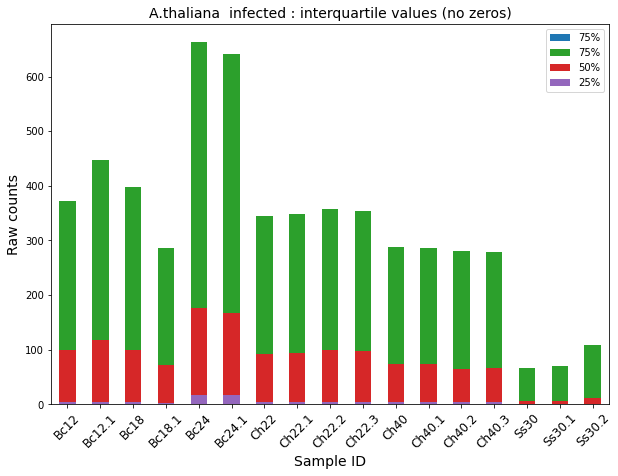

In [39]:
plot_intercuartile_bar(df_tmp, 'A.thaliana '+ general_titles +': interquartile values (no zeros)','Raw counts')
#df_tmp.to_csv("../results-data/statistics/all_raw_healthy_stats_noZeros.csv", index=False, header=True)

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


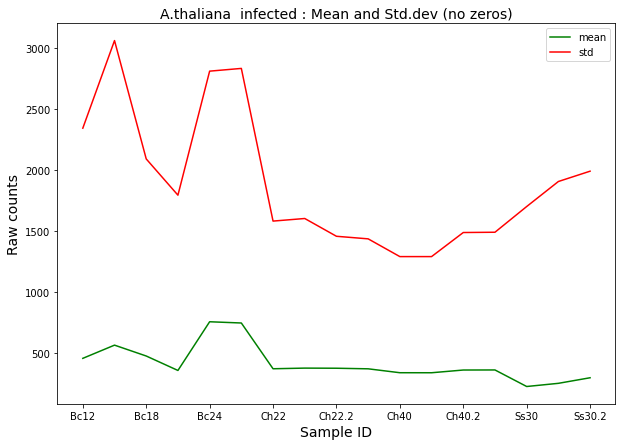

In [40]:
plot_mean_sdev_line(df_tmp,'A.thaliana '+ general_titles +': Mean and Std.dev (no zeros)','Raw counts')

In [41]:
## check Q1 , Q2 or Q3
col_ceros = df_tmp['75%'].tolist()
col_ceros.sort(reverse=False)
print(col_ceros)

[66.0, 70.0, 108.0, 279.0, 281.0, 287.0, 287.0, 288.0, 344.0, 349.0, 354.0, 357.0, 373.0, 398.0, 447.0, 642.0, 663.0]


### Now explore the new distributions with no zeros across all samples
Plot all the sample in one plot (histogram and KDE)

In [43]:
# load file to be plotted
#print(os.getcwd())
if general_titles == 'healthy':
    df_nozeros = pd.read_csv("../results-data/all_healthy_raw_8ceros_drop.csv", sep='\t')  
else:
    df_nozeros = pd.read_csv("../results-data/all_infected_raw_17ceros_drop.csv", sep='\t')  
# dropping not-useful columns 
df_nozeros.drop(["Genes", "zero-counter"], axis = 1, inplace = True) 
print(df_nozeros.head(3))

   Ss30.1  Bc12  Ch40.2  Ch22.2  Ch22.1  Ch22  Ss30.2  Ch22.3  Bc12.1  Bc24.1  \
0      40   141     123     184     160   176      38     199     165     140   
1      33     6      10      10       8     8      41       7      20      59   
2      57  1057     631    1063     917   856     106    1082    1334    1176   

   Bc18.1  Ch40.3  Ch40.1  Bc18  Bc24  Ss30  Ch40  
0     120     105     123   168   149    34   127  
1      19      11       7    22    52    21    13  
2     898     613     613  1218  1149    74   647  


Plot both the histogram and densities in the same plot with the seaborn package (imported as sns) which allows you to do that via the distplot(). 
Since seaborn is built on top of matplotlib, you can use the sns and plt one after the other.

In [44]:
## Get sample list names
sample_lst=df_nozeros.columns
print(sample_lst)
df_nozeros.head(5)

Index(['Ss30.1', 'Bc12', 'Ch40.2', 'Ch22.2', 'Ch22.1', 'Ch22', 'Ss30.2',
       'Ch22.3', 'Bc12.1', 'Bc24.1', 'Bc18.1', 'Ch40.3', 'Ch40.1', 'Bc18',
       'Bc24', 'Ss30', 'Ch40'],
      dtype='object')


,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127
1,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13
2,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647
3,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284
4,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525


[33, 57, 18, 3, 4, 67, 406, 94, 0]
[6, 1057, 1246, 798, 89, 1370, 1367, 773, 10]
[10, 631, 258, 488, 96, 156, 643, 605, 2]
[10, 1063, 426, 377, 42, 275, 799, 1071, 4]
[8, 917, 437, 176, 88, 270, 797, 873, 2]
[8, 856, 412, 164, 63, 277, 846, 863, 2]
[41, 106, 50, 1, 3, 70, 724, 187, 1]
[7, 1082, 465, 353, 38, 274, 858, 1014, 3]
[20, 1334, 1608, 1058, 108, 1584, 1615, 892, 18]
[59, 1176, 857, 136, 111, 634, 2198, 1280, 111]
[19, 898, 714, 10960, 54, 601, 1371, 640, 4]
[11, 613, 247, 517, 91, 128, 586, 605, 1]
[7, 613, 313, 474, 68, 161, 614, 782, 1]
[22, 1218, 871, 13574, 96, 716, 1766, 1230, 6]
[52, 1149, 1000, 102, 132, 735, 2419, 1445, 115]
[21, 74, 25, 2, 9, 51, 382, 106, 0]
[13, 647, 284, 525, 77, 153, 538, 837, 0]


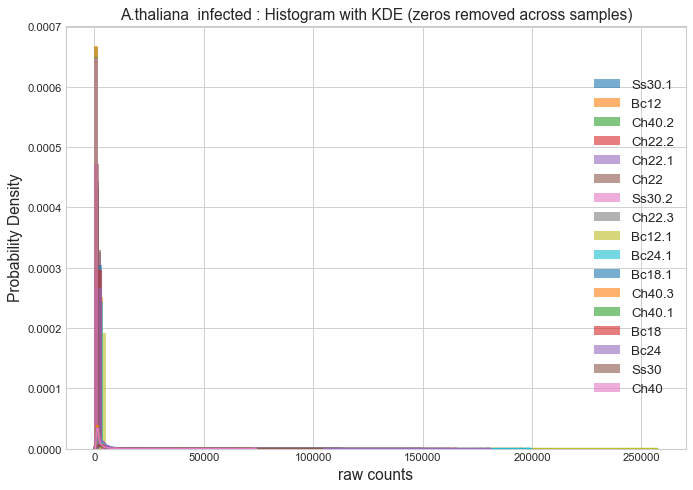

In [46]:
# Plot the distributions: values are raw data - not normalized 
plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    sample_data = df_nozeros[file].tolist()
    print(sample_data[1:10])
    #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('A.thaliana '+ general_titles +': Histogram with KDE (zeros removed across samples)',fontsize=14);
plt.xlabel('raw counts',fontsize=14);
plt.ylabel('Probability Density',fontsize=14);
## add arbitrary lines to canvas
#plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
#plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
plt.legend(loc='center right',fontsize=12);    
#plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");